In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from random import seed, shuffle
import os

import soundfile as sf
import librosa

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

from sklearn.cluster import KMeans, SpectralClustering

from scipy import stats
from scipy.spatial.distance import directed_hausdorff, euclidean, cosine, pdist

from src.downsample import downsamp_audio
import src.embedding_extractor as ee
import src.dimension_reducer as dr
import src.distance_metrics as dm

from IPython.display import clear_output

import warnings
warnings.filterwarnings('ignore')

#from pydub import AudioSegment
#from pyannote.audio.utils.signal import Binarize, Peak
#from pyannote.core import Segment, notebook, SlidingWindowFeature, timeline, Timeline

#Specify path to codec exe used by pydub
#AudioSegment.converter='C:\\Users\\MrBrito\\Documents\\ffmpeg\\ffmpeg-2021-04-20-git-718e03e5f2-full_build\\ffmpeg-2021-04-20-git-718e03e5f2-full_build\\bin\\ffmpeg.exe'

one_samp_toy_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/one_samp_toy_downsamp' #toy dataset with one participant recording @16kHz
#two_samp_toy_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/two_samp_toy_downsamp'#toy dataset with two participant recordings @16kHz
two_samp_toy_dir ='/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/020422_postpartum_moms_two_samp_toy'
down_sampled_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/Full_Readings/downsamp'#all the data, downsampled to 16kHz
embedding_dir = '/Users/rahulbrito/Documents/projects/infantvoice/data/embeddings' #location of embeddings save new embeddings load pre-generated ones from here
emb_models = ['emb_ami', 'emb','emb_voxceleb'] #names of pretrained embedding extractor models

#the directory has other csvs and i only want today's
file = [file for file in os.listdir(embedding_dir) if file.startswith("020322")] 

#create a dictionary where each item is the pd df of the embeddings extracted from that model
all_embs = {emb_models[index]: ee.load_embs(os.path.join(embedding_dir,file[index])) for index in np.arange(len(file))}

Using cache found in /Users/rahulbrito/.cache/torch/hub/pyannote_pyannote-audio_master
Using cache found in /Users/rahulbrito/.cache/torch/hub/pyannote_pyannote-audio_master


In [4]:
## Downsample embeddings if desired for all embedding models in the dictionary. The function will shuffle all the emebddings for one participant and then average N_to_avg together.
#if N_to_avg=1 then the embeddings are just shuffled (recommended to try to dissasociate embeddings from the same utterance, though maybe doesn't matter

emb_down = {model:ee.resample_data(emb,1) for model, emb in all_embs.items()}
emb_down[emb_models[0]]


,0,1,2,3,4,5,6,7,8,9,...,503,504,505,506,507,508,509,510,511,part_id
0,0.194343,0.471711,0.131104,0.677707,0.321199,0.310486,-0.004596,0.543406,0.264374,-0.298936,...,-0.364405,0.419861,-0.430835,-0.000594,-0.490452,0.057084,0.239600,0.226428,0.399464,1.0
1,0.160379,0.280484,-0.136715,0.378592,0.417364,0.191452,-0.038418,0.408640,0.125927,0.009876,...,-0.354433,0.124826,-0.329983,-0.161874,0.023193,0.185698,0.134647,0.251257,0.448312,1.0
2,0.295241,0.123536,0.171945,0.360826,0.111145,0.569962,0.052106,0.494581,0.391834,0.073833,...,-0.108068,0.377034,-0.187074,-0.003769,-0.031741,-0.147246,0.137283,0.247948,-0.004698,1.0
3,0.091887,0.423360,0.092663,0.502809,0.290929,0.173898,0.062774,0.521282,0.067453,-0.080352,...,-0.344168,0.228168,-0.506681,0.045968,-0.319835,0.150278,0.086740,0.144810,0.377718,1.0
4,0.175649,0.415603,-0.185651,0.492292,0.439957,0.255900,-0.034511,0.590731,-0.008688,-0.011961,...,-0.161451,0.153969,-0.293978,-0.078539,-0.315034,0.137735,-0.146024,-0.051389,0.379904,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
950,0.021316,0.043647,0.027422,-0.301829,0.144173,-0.233311,-0.205716,0.085876,0.959766,0.021038,...,0.470724,-0.299614,-0.148868,0.200104,0.050248,0.312484,-0.072785,-0.324384,-0.332852,18.0
951,-0.052177,-0.119640,-0.107651,-0.094877,0.003573,-0.304978,-0.201123,0.108165,0.746920,-0.120477,...,-0.203408,0.113964,-0.146158,-0.305759,0.115214,-0.301779,-0.055726,-0.049070,-0.185870,18.0
952,-0.158692,-0.278002,-0.012681,0.084801,0.031951,-0.137629,-0.096224,0.457641,0.497975,-0.139826,...,0.096412,-0.129896,0.018725,0.080919,0.127126,-0.039775,-0.019562,-0.031750,-0.390761,18.0
953,0.289247,-0.146979,-0.055897,0.017395,0.421804,-0.239203,-0.416958,0.163335,0.762974,-0.259255,...,-0.014656,-0.078116,-0.206980,-0.458367,0.228677,-0.426595,-0.235420,-0.152868,-0.396310,18.0


In [6]:
##Run variations of tSNE from Kobak & Berens 2019 'The art of using t-SNE for single-cell transcriptomics'
#perpexity = 30, init='random',learning_rate=200
emb_tsne_def = {mod:dr.run_tsne(ed) for mod, ed in emb_down.items()}

#**perpexity = n/100**, init='random',learning_rate=200
emb_tsne_1pp = {mod:dr.run_tsne(ed, perplexity = -(-ed.shape[0]//100)) for mod, ed in emb_down.items()}

#perpexity = 30, **init='pca'**,learning_rate=200
emb_tsne_pca = {mod:dr.run_tsne(ed, init='pca') for mod, ed in emb_down.items()}

#**multiscale: perpexity = n/100, **init='pca'**,learning_rate=200**
#should be perplexity = n/100 when n/100>>30
emb_tsne_multi = {mod:dr.run_tsne(ed, perplexity = -(-ed.shape[0]//100), init='pca', learning_rate=ed.shape[0]//12) for mod, ed in emb_down.items()}

In [7]:
#Run UMAP to compare
emb_umap = {model:dr.run_umap(ed) for model, ed in emb_down.items()}

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [14]:
#calculate hausdorf distances for all models and default dimension reduction techniques
haus_tsne = {model:dm.hausdorff_distances(e2d) for model, e2d in emb_tsne_def.items()}

haus_umap = {model:dm.hausdorff_distances(e2d) for model, e2d in emb_umap.items()}

haus_tsne = {model: haus.where(np.triu(np.ones(haus.shape), k=1).astype(np.bool)) for model, haus in haus_tsne.items()}
haus_tsne_flat = {model: haus.stack().reset_index() for model, haus in haus_tsne.items()}

Processing row 17, col 17


In [8]:
## try to implement KNN, KNC, CPD metrics to evaluate dim reduc from https://github.com/berenslab/rna-seq-tsne/blob/master/toy-example.ipynb
dist = []

[dist.append(
    dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(), 
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),
        'tsne_def',
        subsetsize=100
    )
) 
 for (X,Z) in zip(emb_down.values(), emb_tsne_def.values())
]

[dist.append(
    dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(), 
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),
        'tsne_1pp',
        subsetsize=100
    )
) 
 for (X,Z) in zip(emb_down.values(), emb_tsne_1pp.values())
]

[dist.append(
    dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(), 
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),
        'tsne_pca',
        subsetsize=100
    )
) 
 for (X,Z) in zip(emb_down.values(), emb_tsne_pca.values())
]

[dist.append(
    dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(),
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),'tsne_multi',
        subsetsize=100
    )
) 
 for (X,Z) in zip(emb_down.values(), emb_tsne_multi.values())
]

[dist.append(
    dm.embedding_quality(
        X.drop(columns='part_id').to_numpy(), 
        Z.drop(columns='part_id').to_numpy(), 
        X.part_id.to_numpy(),'umap',
        subsetsize=100
    )
) 
 for (X,Z) in zip(emb_down.values(), emb_umap.values())
]


dist = pd.DataFrame(dist, index = emb_models*5, columns = ['micro', 'meso', 'macro','dim_reduc'])
#dist = pd.DataFrame(dist, index = emb_models*4, columns = ['knn', 'knc', 'cpd','dim_reduc'])
dist

,micro,meso,macro,dim_reduc
emb_ami,0.586806,0.672222,0.482492,tsne_def
emb,0.588691,0.750000,0.597934,tsne_def
emb_voxceleb,0.338416,0.833333,0.617775,tsne_def
emb_ami,0.581466,0.711111,0.460694,tsne_1pp
emb,0.581152,0.705556,0.481316,tsne_1pp
emb_voxceleb,0.335204,0.822222,0.681418,tsne_1pp
emb_ami,0.588691,0.666667,0.506569,tsne_pca
emb,0.586073,0.661111,0.532353,tsne_pca
emb_voxceleb,0.339118,0.833333,0.752962,tsne_pca
emb_ami,0.580105,0.655556,0.551676,tsne_multi


In [12]:
dist[dist.index == 'emb_ami'] 

,micro,meso,macro,dim_reduc
emb_ami,0.586806,0.672222,0.482492,tsne_def
emb_ami,0.581466,0.711111,0.460694,tsne_1pp
emb_ami,0.588691,0.666667,0.506569,tsne_pca
emb_ami,0.580105,0.655556,0.551676,tsne_multi
emb_ami,0.504398,0.633333,0.377768,umap


In [11]:
dist[dist.index == 'emb']

,micro,meso,macro,dim_reduc
emb,0.588691,0.750000,0.597934,tsne_def
emb,0.581152,0.705556,0.481316,tsne_1pp
emb,0.586073,0.661111,0.532353,tsne_pca
emb,0.579476,0.655556,0.481935,tsne_multi
emb,0.507120,0.588889,0.321711,umap


In [13]:
dist[dist.index == 'emb_voxceleb']

,micro,meso,macro,dim_reduc
emb_voxceleb,0.338416,0.833333,0.617775,tsne_def
emb_voxceleb,0.335204,0.822222,0.681418,tsne_1pp
emb_voxceleb,0.339118,0.833333,0.752962,tsne_pca
emb_voxceleb,0.333552,0.833333,0.661767,tsne_multi
emb_voxceleb,0.205679,0.627778,0.261737,umap


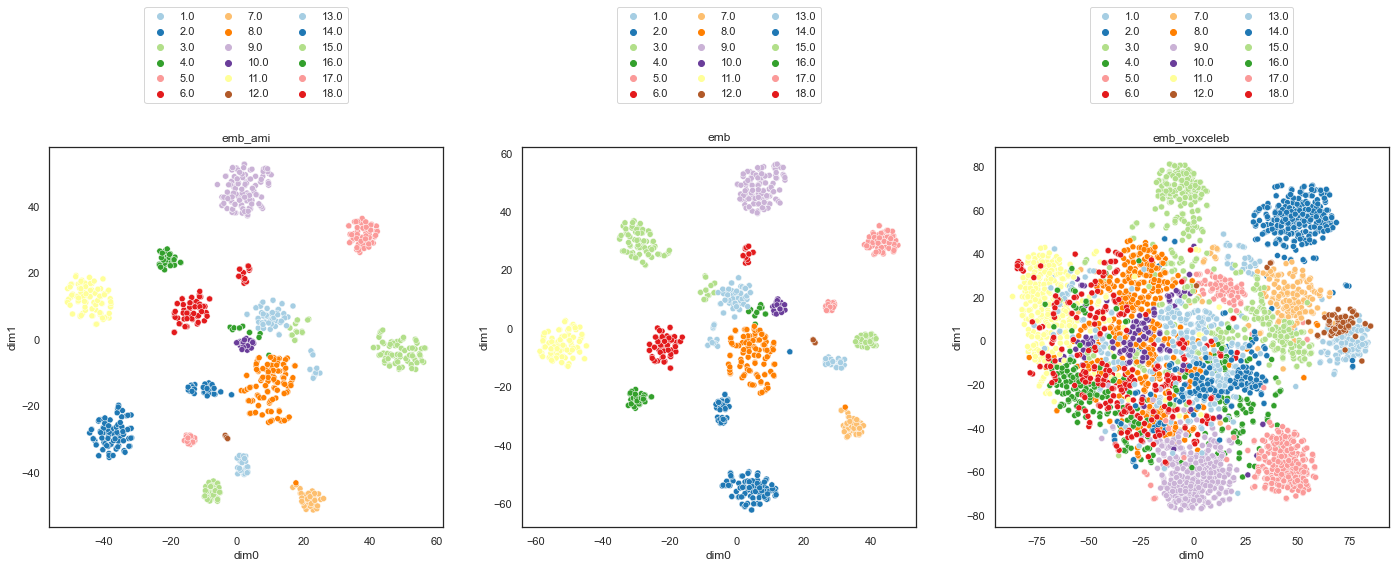

In [44]:
df = emb_tsne_def
sns.set_theme(style="white")
fig, ax = plt.subplots(ncols=3, figsize=(24,7))
[sns.scatterplot(x=df[model].dim0, y=df[model].dim1, palette="Paired", hue=df[model].part_id, ax=ax[emb_models.index(model)]).set(title=model) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)for model in emb_models]

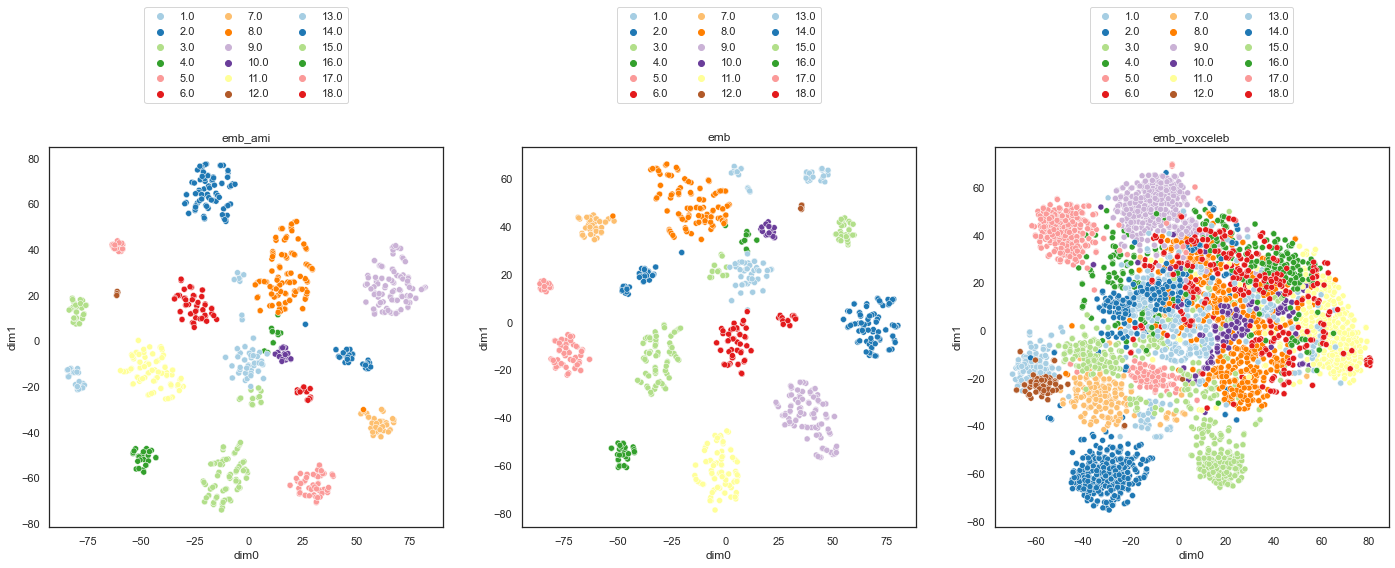

In [43]:
df = emb_tsne_1pp

sns.set_theme(style="white")
fig, ax = plt.subplots(ncols=3, figsize=(24,7))

[sns.scatterplot(x=df[model].dim0, y=df[model].dim1, palette="Paired", hue=df[model].part_id, ax=ax[emb_models.index(model)]).set(title=model) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)for model in emb_models]

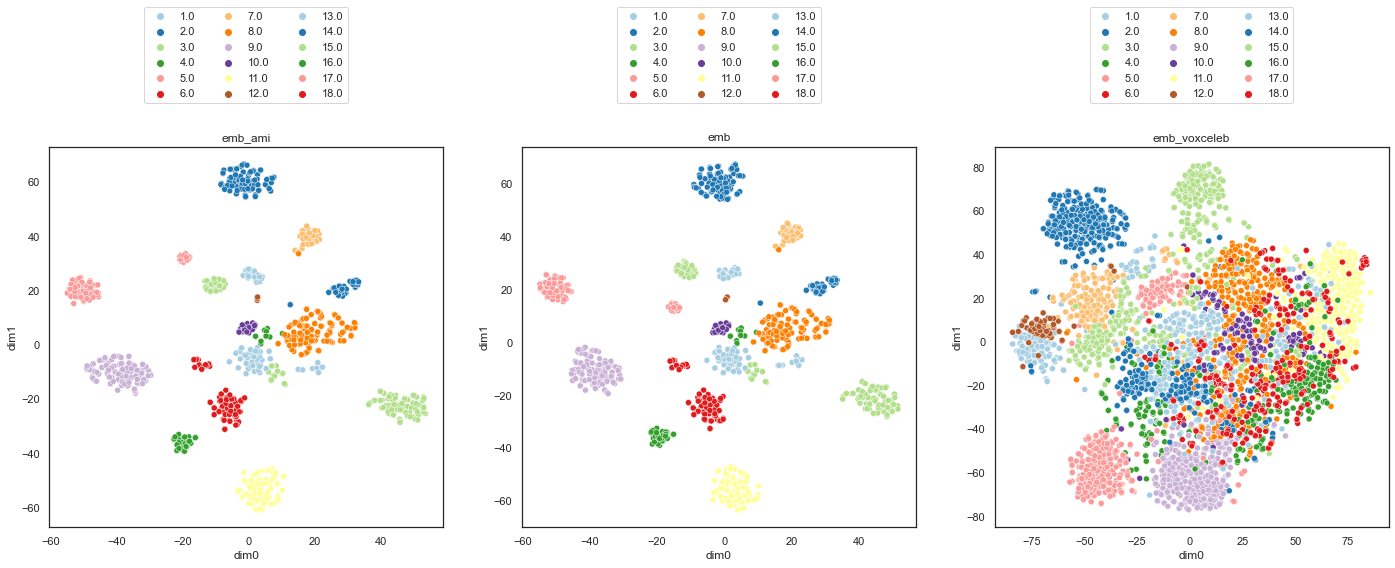

In [41]:
df = emb_tsne_pca

sns.set_theme(style="white")
fig, ax = plt.subplots(ncols=3, figsize=(24,7))

[sns.scatterplot(x=df[model].dim0, y=df[model].dim1, palette="Paired", hue=df[model].part_id, ax=ax[emb_models.index(model)]).set(title=model) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)for model in emb_models]

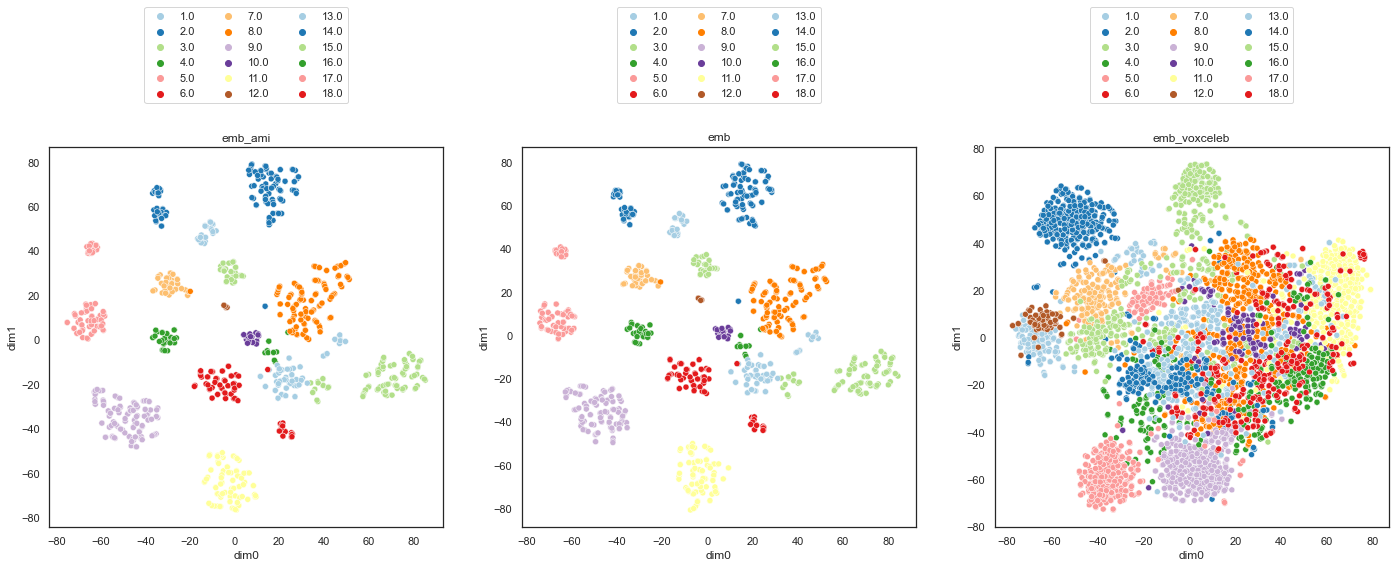

In [40]:
df = emb_tsne_multi

sns.set_theme(style="white")
fig, ax = plt.subplots(ncols=3, figsize=(24,7))

[sns.scatterplot(x=df[model].dim0, y=df[model].dim1, palette="Paired", hue=df[model].part_id, ax=ax[emb_models.index(model)]).set(title=model) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)for model in emb_models]

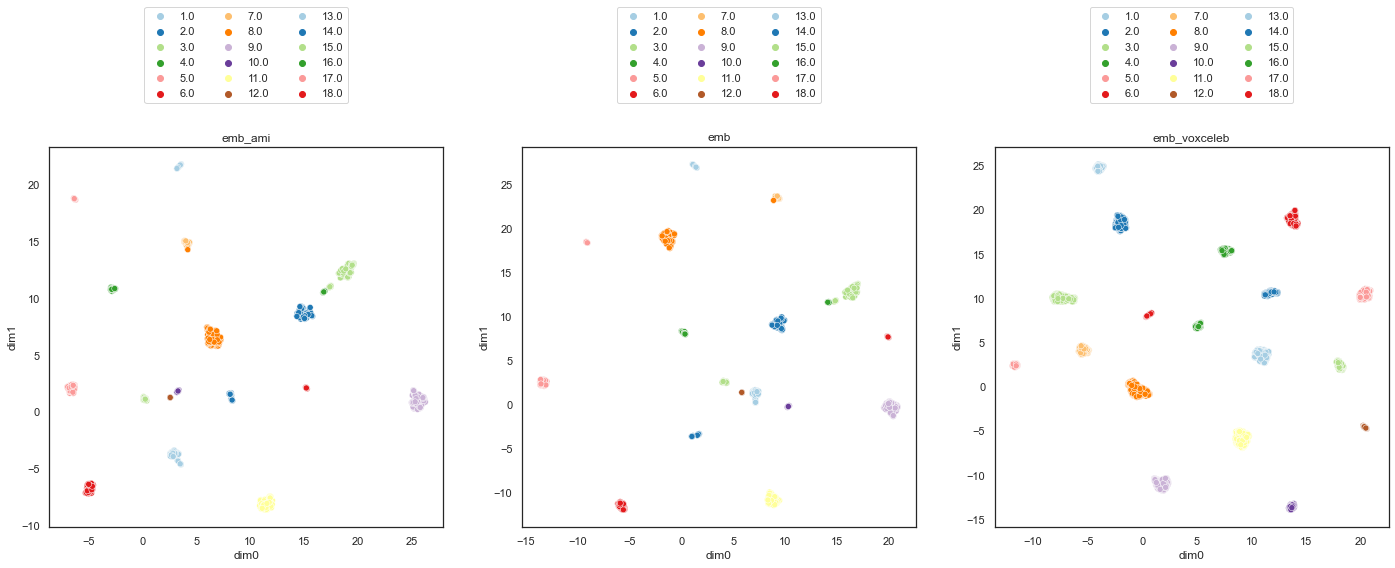

In [42]:
df = emb_umap

sns.set_theme(style="white")
fig, ax = plt.subplots(ncols=3, figsize=(24,7))

[sns.scatterplot(x=df[model].dim0, y=df[model].dim1, palette="Paired", hue=df[model].part_id, ax=ax[emb_models.index(model)]).set(title=model) for model in emb_models]
legend1 = [ax[emb_models.index(model)].legend(loc="lower center",bbox_to_anchor=(0.5, 1.1), ncol=3)for model in emb_models]